In [1]:
import os
from utils import load_mat
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model

In [2]:
path_to_data = '/Users/julianstastny/Code/masters-thesis/data/AMED-DFG/behavior'

### Preprocesing

In [45]:
data = []
for i, filename in enumerate(os.listdir(path_to_data)):
    if filename.startswith('behavior') and filename.endswith('.mat'):
        datapoint = load_mat(os.path.join(path_to_data, filename))
        important_info = datapoint['bsum']['raw']['apav']
        important_info.pop('basal', None)
        if any([important_info[key]['datanum'] <= 1 for key in important_info.keys()]):
            continue
        for key in important_info.keys():
            for key_2 in list(important_info[key].keys()):
                if not (key_2 in ['reward_amount', 'aversi_amount', 'appro1_avoid0', 'reaction_time', 'push1_pull0']):
                    important_info[key].pop(key_2, None)
            as_pandas_df = pd.DataFrame.from_dict(important_info[key])
            important_info[key] = as_pandas_df
        important_info['metadata'] = {'monkey_id': datapoint['fsum']['monkey'], 'datetime': datapoint['fsum']['session']}
        data += [important_info]
print(len(data))


### Plot progression of decision boundary over non-stimulated, stimulated and extended session

190


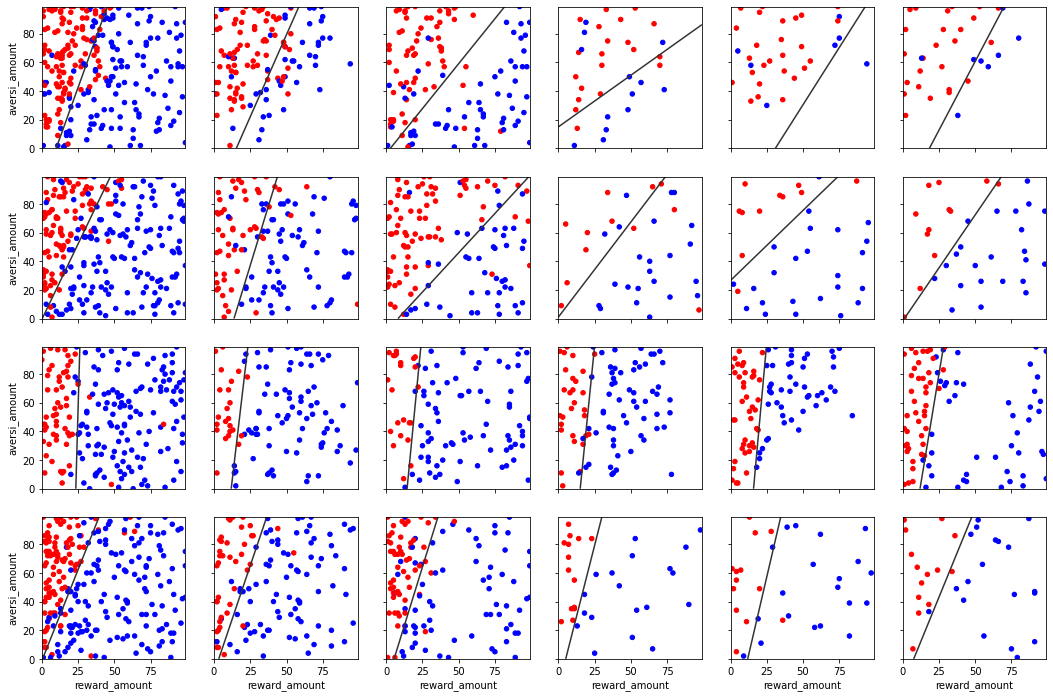

In [71]:
num_blocks_stim1 = 2
num_blocks_resid = 3
num_rows = 4
num_cols = 1 + num_blocks_stim1 + num_blocks_resid
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 3, num_rows * 3))

clf = linear_model.LogisticRegression()

def chunks(df, n):
    """Yield successive n-sized chunks from df."""
    for i in range(0, len(df), n):
        yield df.iloc[i:i + n]

def plot_all(X, y, i, j):
    ax = axes[i, j]

    clf.fit(X, y)

    xx, yy = np.mgrid[0:100:1, 0:100:1]
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
    ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    X.plot.scatter('reward_amount', 'aversi_amount', c=y, colormap='bwr_r', ax=ax, sharex=True, sharey=True, colorbar=False)

for i in range(num_rows):

    stage = 'stim0'
    X = data[i][stage][['reward_amount', 'aversi_amount']]
    y = data[i][stage]['appro1_avoid0']
    plot_all(X, y, i, 0)

    stage = 'stim1'
    num_chunks = len(data[i][stage]) // num_blocks_stim1
    X = chunks(data[i][stage][['reward_amount', 'aversi_amount']], num_chunks)
    y = chunks(data[i][stage]['appro1_avoid0'], num_chunks)
    for j in range(1, num_blocks_stim1 + 1):
        plot_all(next(X), next(y), i, j)

    stage = 'resid'
    num_chunks = len(data[i][stage]) // num_blocks_resid
    X = chunks(data[i][stage][['reward_amount', 'aversi_amount']], num_chunks)
    y = chunks(data[i][stage]['appro1_avoid0'], num_chunks)
    for j in range(num_blocks_stim1+1, num_blocks_stim1 + num_blocks_resid + 1):
        plot_all(next(X), next(y), i, j)



### Differentiating between positive and negative stimulation

In [80]:
clf0 = linear_model.LogisticRegression()
clf1 = linear_model.LogisticRegression()

for i in range(len(data)):
    X_stim0 = data[i]['stim0'][['reward_amount', 'aversi_amount']]
    y_stim0 = data[i]['stim0']['appro1_avoid0']

    X_stim1 = data[i]['stim1'][['reward_amount', 'aversi_amount']]
    y_stim1 = data[i]['stim1']['appro1_avoid0']

    clf0.fit(X_stim0, y_stim0)
    clf1.fit(X_stim1, y_stim1)
    ap_prob_stim0 = clf0.predict_proba([[50, 50]])[0][1]
    ap_prob_stim1 = clf1.predict_proba([[50, 50]])[0][1]
    data[i]['metadata']['stim_increases_avoidance'] = True if (ap_prob_stim0 > ap_prob_stim1) else False

### Plot no stimulation, negative stimulation and positive stimulation

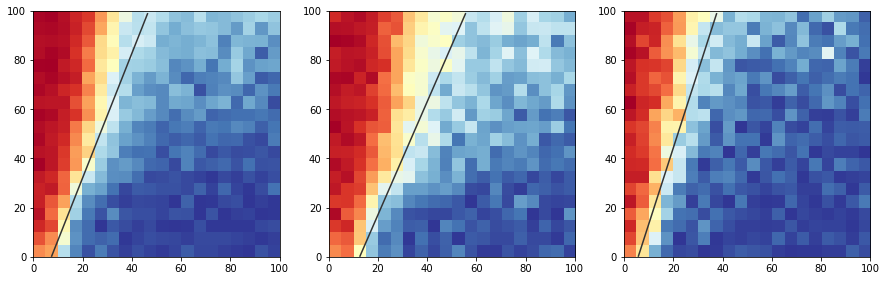

In [86]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

clf = linear_model.LogisticRegression()

def plot_heatmap(x, y, w, i):
    ax = axes[i]
    H, xedges, yedges = np.histogram2d(x, y, bins=20, weights=w)
    H2, _, _ = np.histogram2d(x,y, bins=20)
    H2 += 1
    H += 1
    extent = [0,100, 0, 100]
    ax.imshow(np.flipud((H/H2).T), extent=extent,interpolation='nearest', cmap='RdYlBu_r')
    # ax.colorbar()

    clf.fit(pd.concat((x, y), axis=1), w)

    xx, yy = np.mgrid[0:100:1, 0:100:1]
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
    ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)

stage = 'stim0'
x, y, w = [], [], []
for i in range(len(data)):
    X = data[i][stage][['reward_amount', 'aversi_amount']]
    x += [X['reward_amount']]
    y += [X['aversi_amount']]
    w += [1 - data[i][stage]['appro1_avoid0']]
x = pd.concat(x)
y = pd.concat(y)
w = pd.concat(w)
plot_heatmap(x, y, w, 0)

stage = 'stim1'
x, y, w = [], [], []
for i in range(len(data)):
    if data[i]['metadata']['stim_increases_avoidance']:
        X = data[i][stage][['reward_amount', 'aversi_amount']]
        x += [X['reward_amount']]
        y += [X['aversi_amount']]
        w += [1 - data[i][stage]['appro1_avoid0']]
x = pd.concat(x)
y = pd.concat(y)
w = pd.concat(w)
plot_heatmap(x, y, w, 1)

x, y, w = [], [], []
for i in range(len(data)):
    if not data[i]['metadata']['stim_increases_avoidance']:
        X = data[i][stage][['reward_amount', 'aversi_amount']]
        x += [X['reward_amount']]
        y += [X['aversi_amount']]
        w += [1 - data[i][stage]['appro1_avoid0']]
x = pd.concat(x)
y = pd.concat(y)
w = pd.concat(w)
plot_heatmap(x, y, w, 2)

